<a href="https://colab.research.google.com/github/idouglas11/Foster-Partners/blob/main/foster%2Bpartners.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Date: 6/2/2024

Author: Isobel Douglas

In [ ]:
# Install packages that are not in the default site library
install.packages("png")
install.packages("googledrive")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
# Load in all the libraries

library(dplyr)
library(ggplot2)
library(httr)
library(jsonlite)
library(tidyr)
library(lubridate)
library(tidyverse)
library(png)
library(googledrive)
library(grid)



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats 1.0.0     ✔ stringr 1.5.1
✔ purrr   1.0.2     ✔ tibble  3.2.1
✔ readr   2.1.5     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ purrr::flatten() masks jsonlite::flatten()
✖ dplyr::lag()     masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Load in data

In [ ]:
# Read in the JSON files
iaq_raw <- fromJSON(
  txt = "https://fpardrecruiting002st.z33.web.core.windows.net/CodeEvaluation/DataScientist/iaq.json"
  )

oaq_raw <- fromJSON(
  txt = "https://fpardrecruiting002st.z33.web.core.windows.net/CodeEvaluation/DataScientist/oaq.json"
)

# contains png data in the "image" column and sensor locations nested in the "sensors" column
floors_raw <- fromJSON(
  txt = "https://fpardrecruiting002st.z33.web.core.windows.net/CodeEvaluation/DataScientist/floors.json"
)

Check for missing data

In [ ]:
# iaq
str(iaq_raw)
summary(iaq_raw)

# oaq
str(oaq_raw)
summary(oaq_raw)


# floors
str(floors_raw)
summary(floors_raw)


Clean and format the data so it is ready for analysis and future
forecasting uses.

In [ ]:
# Clean the floors data

# Create an empty list to store cleaned data frames
sensors_list <- list()

# Loop through sensors to extract information
for (i in 1:length(floors_raw$sensors)) {
  sensor <- floors_raw$sensors[[i]]
  sensor_clean <- data.frame(
    sensor_id = sensor$sensor_id,
    x_loc = sensor$location$x,
    y_loc = sensor$location$y
  )
  sensors_list[[i]] <- sensor_clean
}

# Add in floor information and combine into one df

h3f_clean <- sensors_list[[1]] %>%
  mutate(floor = "3")
h4f_clean <- sensors_list[[2]] %>%
  mutate(floor = "4")

sensor_info <- rbind(h3f_clean, h4f_clean)
head(sensor_info)

# Extract the images paths from the dataframe

img <- floors_raw$image
h3f_path <- img$name[1]
h4f_path <- img$name[2]

,sensor_id,x_loc,y_loc,floor
,<chr>,<dbl>,<dbl>,<chr>
1,ENKZYW001792,355.19,487.47,3
2,ENKZYW001804,203.47,313.77,3
3,ENKZYW001819,387.91,153.54,3
4,ENKZYW001837,609.73,134.67,3
5,ENKZYW001848,891.23,156.61,3
6,ENKZYW001856,920.65,314.84,3


In [ ]:
# Clean the iaq data
# Convert the datetime varibale into posixct
iaq_clean <- iaq_raw %>%
  mutate(
    documentTime = as.POSIXct(documentTime, format="%Y-%m-%dT%H:%M:%S.000Z")
  )

# Clean the oaq data

oaq_clean <- oaq_raw %>%
  mutate(
    documentTime = as.POSIXct(documentTime, format="%Y-%m-%dT%H:%M:%S+00:00")
  )


Combine the floor and iaq data so we can map the sensors to the correct floor.

In [ ]:
# Join the tables

iaq_floors <- left_join(iaq_clean, sensor_info, by = "sensor_id")

head(iaq_floors)

,documentTime,temp,humidity,co2,sensor_id,x_loc,y_loc,floor
,<dttm>,<dbl>,<int>,<dbl>,<chr>,<dbl>,<dbl>,<chr>
1,2023-01-23 00:03:37,23.5,22,788,ENKZYW001792,355.19,487.47,3
2,2023-01-23 00:00:48,23.6,23,778,ENKZYW001804,203.47,313.77,3
3,2023-01-23 00:04:53,22.0,25,785,ENKZYW001882,875.91,488.12,3
4,2023-01-23 00:01:33,23.2,47,449,ENKZYW001856,920.65,314.84,3
5,2023-01-23 00:04:29,22.8,23,780,ENKZYW001848,891.23,156.61,3
6,2023-01-23 00:04:18,23.6,23,796,ENKZYW001837,609.73,134.67,3


Create some exploratory plots

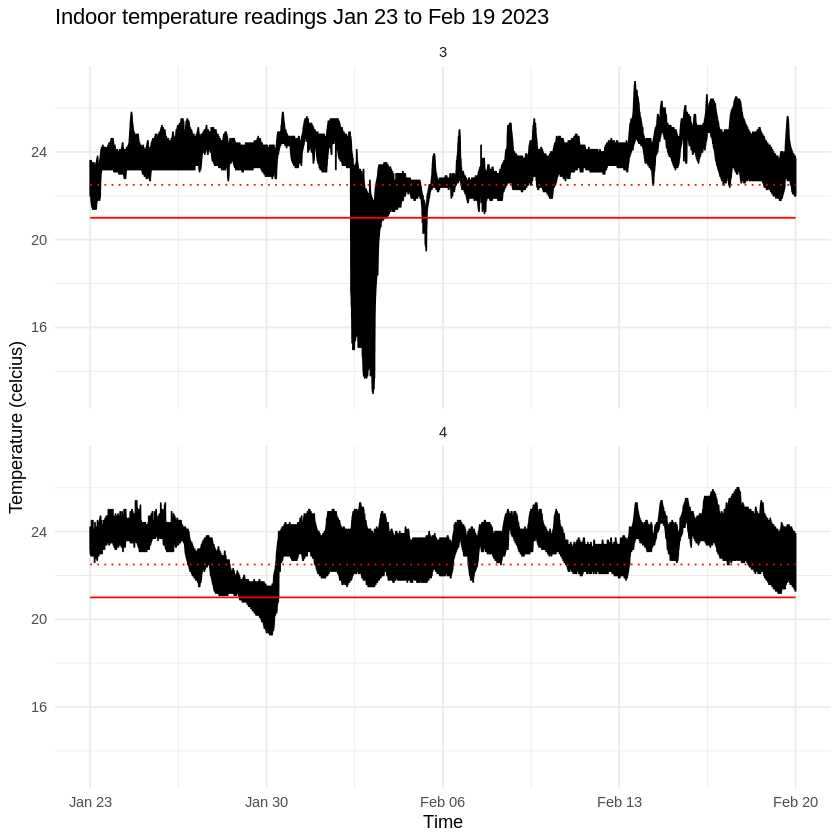

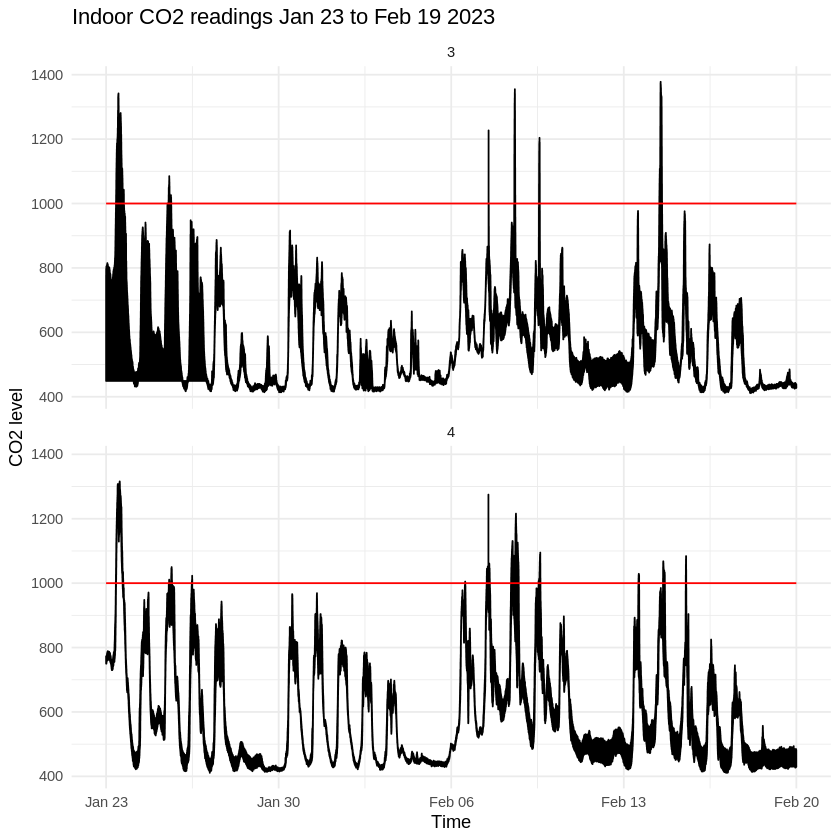

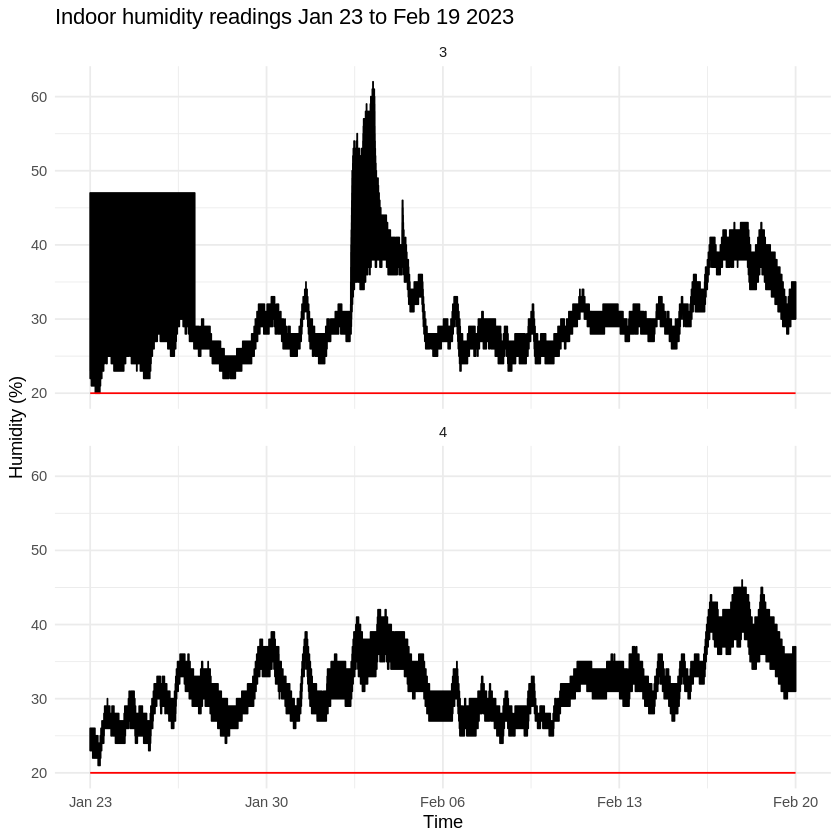

In [ ]:
# plot the temperature data

iaq_floors %>%
  ggplot(aes(x=documentTime, y=temp)) +
    geom_line() +
    geom_line(y=21, colour="red") +
    geom_line(y=22.5, colour="red", linetype=3) +       # temp at desk height is estimated to be 1.5 degrees lower
    theme_minimal() +
    ggtitle("Indoor temperature readings Jan 23 to Feb 19 2023") +
    labs(x="Time", y= "Temperature (celcius)") +
    facet_wrap(~floor, ncol=1)

# Plot the CO2 data
iaq_floors %>%
  ggplot(aes(x=documentTime, y=co2)) +
    geom_line() +
    geom_line(y=1000, colour="red") +
    theme_minimal() +
    ggtitle("Indoor CO2 readings Jan 23 to Feb 19 2023") +
    labs(x="Time", y="CO2 level") +
    facet_wrap(~floor, ncol=1)

# Plot the humidity data
iaq_floors %>%
  ggplot(aes(x=documentTime, y=humidity)) +
    geom_line() +
    geom_line(y=20, colour="red") +
    theme_minimal() +
    ggtitle("Indoor humidity readings Jan 23 to Feb 19 2023") +
    labs(x="Time", y="Humidity (%)") +
    facet_wrap(~floor, ncol=1)


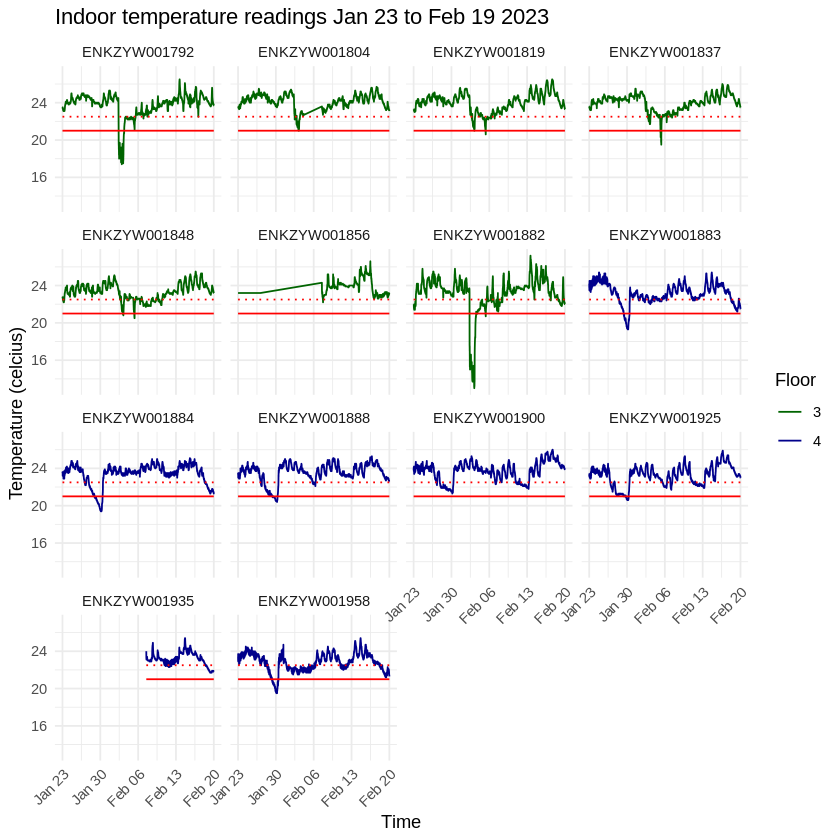

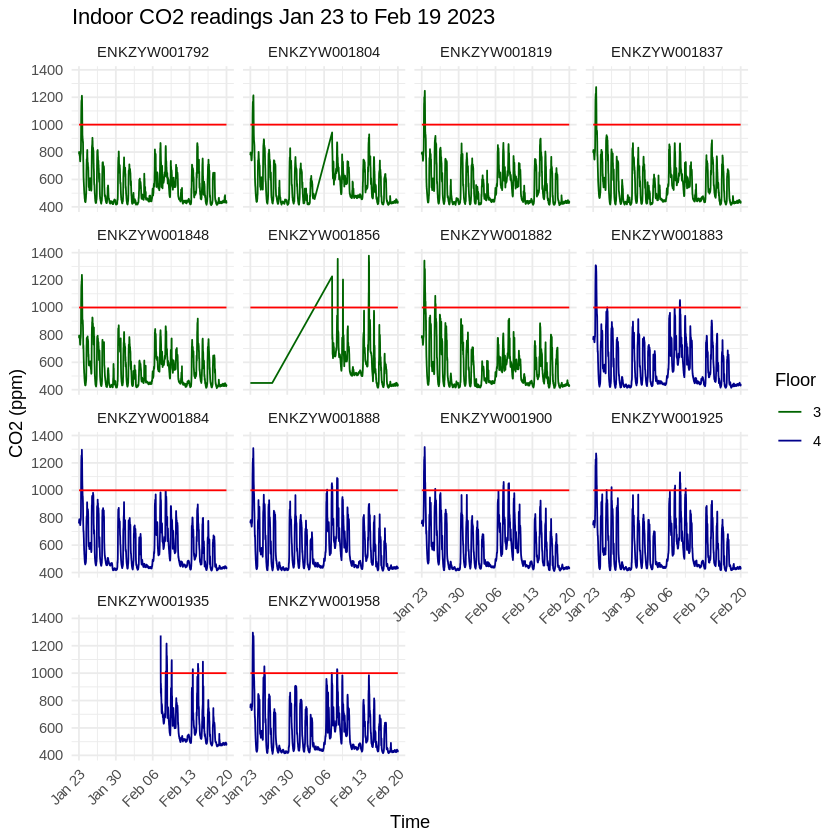

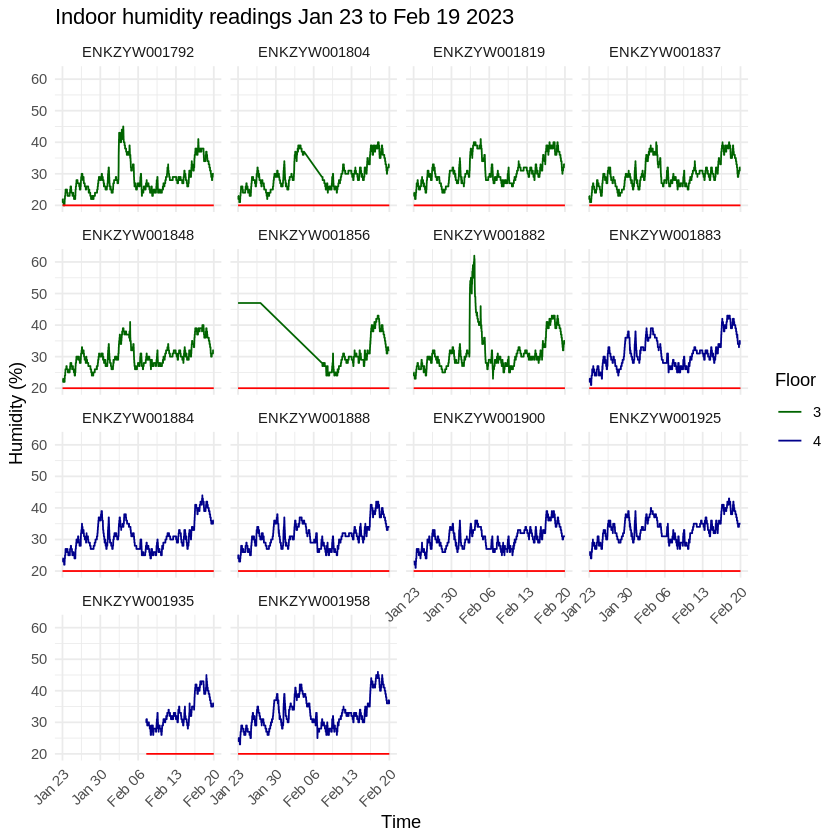

In [ ]:
# Look at the spread across sensors
iaq_floors %>%
  ggplot(aes(x=documentTime, y=temp, colour=floor)) +
    geom_line() +
    geom_line(y=21, colour="red") +
    geom_line(y=22.5, colour="red", linetype=3) +       # temp at desk height is estimated to be 1.5 degrees lower
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1)) +
    scale_colour_manual(values = c("darkgreen", "darkblue")) +
    ggtitle("Indoor temperature readings Jan 23 to Feb 19 2023") +
    labs(x="Time", y="Temperature (celcius)", colour="Floor") +
    facet_wrap(~sensor_id, ncol=4)


# Plot the CO2 data
iaq_floors %>%
  ggplot(aes(x=documentTime, y=co2, colour=floor)) +
    geom_line() +
    geom_line(y=1000, colour="red") +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1)) +
    scale_colour_manual(values = c("darkgreen", "darkblue")) +
    ggtitle("Indoor CO2 readings Jan 23 to Feb 19 2023") +
    labs(x="Time", y="CO2 (ppm)", colour="Floor") +
    facet_wrap(~sensor_id, ncol=4)

# Plot the humidity data
iaq_floors %>%
  ggplot(aes(x=documentTime, y=humidity, colour=floor)) +
    geom_line() +
    geom_line(y=20, colour="red") +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1)) +
    scale_colour_manual(values = c("darkgreen", "darkblue")) +
    ggtitle("Indoor humidity readings Jan 23 to Feb 19 2023") +
    labs(x="Time", y="Humidity (%)", colour="Floor") +
    facet_wrap(~sensor_id, ncol=4)


,documentTime,temperature,humidity,windSpeed
,<dttm>,<dbl>,<dbl>,<dbl>
1,2023-01-23 01:00:00,-1.3,89.5,NA
2,2023-01-23 02:00:00,-1.5,90.0,NA
3,2023-01-23 03:00:00,-1.8,90.0,NA
4,2023-01-23 04:00:00,-2.2,90.7,NA
5,2023-01-23 05:00:00,-2.3,91.0,NA
6,2023-01-23 06:00:00,-2.2,91.0,NA


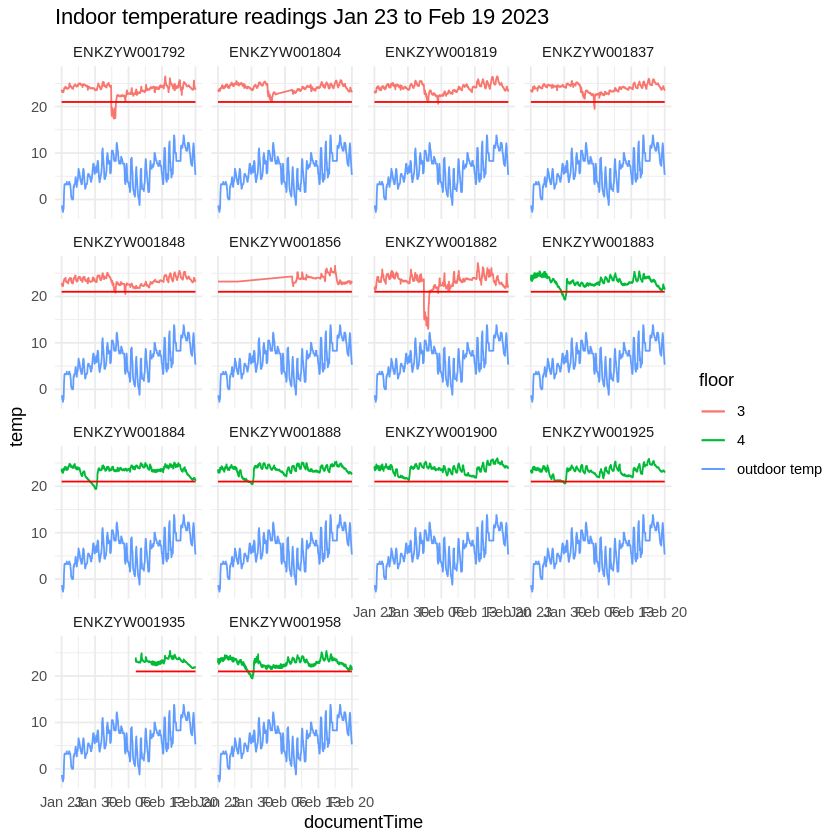

In [ ]:
# Compare the indoor and outdoor air qaulity data

head(oaq_clean)

iaq_floors %>%
  ggplot(aes(x=documentTime, y=temp, colour=floor)) +
    geom_line() +
    geom_line(y=21, colour="red") +
    geom_line(data=oaq_clean, aes(x=documentTime, y=temperature, colour="outdoor temp")) +
    #geom_hline(yintercept = mean(iaq_floors$temp, na.rm = TRUE), color = 'black', lty = 'dashed') +
    theme_minimal() +
    ggtitle("Indoor temperature readings Jan 23 to Feb 19 2023") +
    facet_wrap(~sensor_id, ncol=4)



Use the sensor locations information to get a better understanding on their location in the building for analysis purposes.

In [ ]:
# Download the png floor maps
h3f_file <- drive_find(h3f_path)
h4f_file <- drive_find(h4f_path)

drive_download(h3f_file$id, path=h3f_path)
drive_download(h4f_file$id, path=h4f_path)

h3f_img <- readPNG(h3f_path)
h4f_img <- readPNG(h4f_path)

Please point your browser to the following url: 

https://accounts.google.com/o/oauth2/v2/auth?client_id=603366585132-frjlouoa3s2ono25d2l9ukvhlsrlnr7k.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&redirect_uri=https%3A%2F%2Fwww.tidyverse.org%2Fgoogle-callback%2F&response_type=code&state=160ac466046f8b6e95a76ef93b1597f5&access_type=offline&prompt=consent



Enter authorization code: eyJjb2RlIjoiNC8wQWZKb2hYbndvTHROWHF3TXpZaEtRYnd6QWw1ZjBFdXJqWXBOM2RGNHZQcndOQmltSV9ZenNTMHF2a24yREZSbEJFVVF1QSIsInN0YXRlIjoiMTYwYWM0NjYwNDZmOGI2ZTk1YTc2ZWY5M2IxNTk3ZjUifQ==


File downloaded:

• H-3F.png <id: 1gtT3r2BdggjAiAwbaQ-59bM1YCXxeZEY>

Saved locally as:

• H-3F.png

File downloaded:

• H-4F.png <id: 1I8Tz5rXoaDnZmUV5aal1a6d2t_56HVgk>

Saved locally as:

• H-4F.png



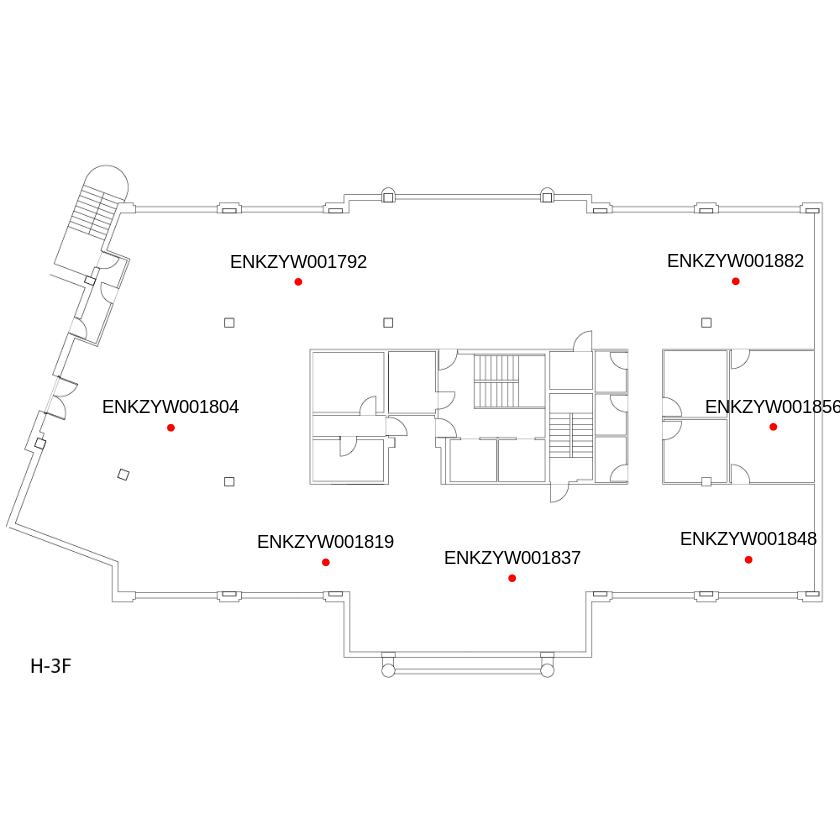

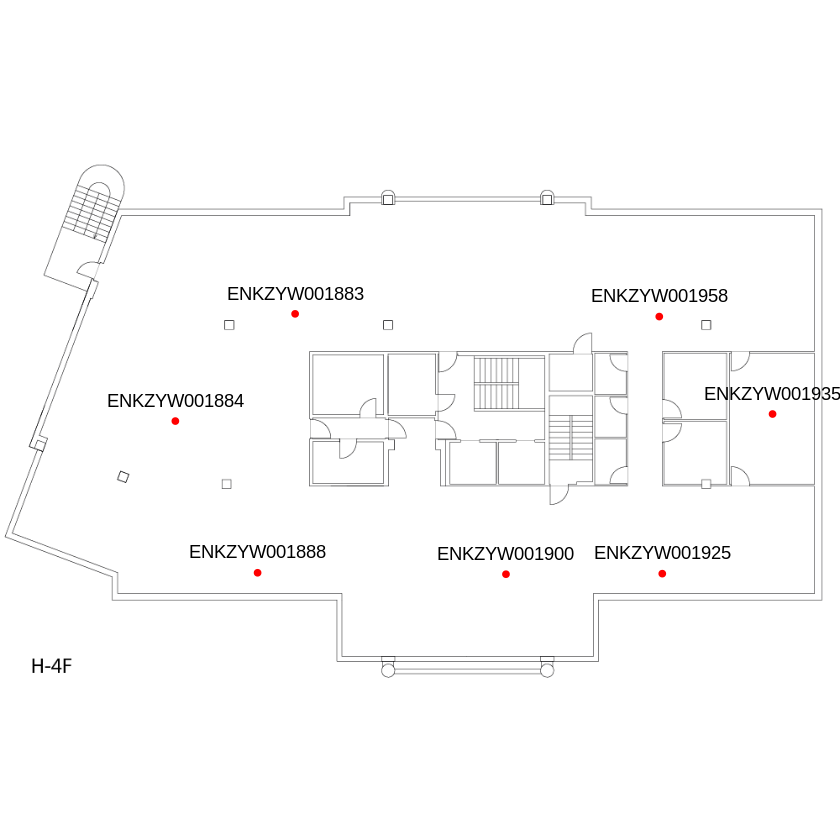

In [ ]:
# Raster the images
floor_3 <- rasterGrob(h3f_img, width=unit(1,"npc"), height=unit(1,"npc"))
floor_4 <- rasterGrob(h4f_img, width=unit(1,"npc"), height=unit(1,"npc"))

# Plot the sensor locations on the map

# Floor 3

sensor_info %>%
  filter(floor == "3") %>%
  ggplot(aes(x=x_loc, y=y_loc, label=sensor_id)) +
    annotation_custom(floor_3)+
    geom_text(vjust=-1.1) +
    geom_point(colour="red") +
    scale_x_continuous(expand=c(0,0), lim=c(0,1000)) +
    scale_y_continuous(expand=c(0,0), lim=c(0,646)) +
    theme_void() +
    theme_void() +
    theme(aspect.ratio = nrow(h3f_img)/ncol(h3f_img))

# Floor 4

sensor_info %>%
  filter(floor == "4") %>%
  ggplot(aes(x=x_loc, y=y_loc, label=sensor_id)) +
    annotation_custom(floor_4)+
    geom_text(vjust=-1.1) +
    geom_point(colour="red") +
    scale_x_continuous(expand=c(0,0), lim=c(0,1000)) +
    scale_y_continuous(expand=c(0,0), lim=c(0,646)) +
    theme_void() +
    theme_void() +
    theme(aspect.ratio = nrow(h4f_img)/ncol(h4f_img))

Look for correlations between the indoor and outdoor data. I decided to use a pearsons correlation based on the linear nature of the data and as it is continous.

In [ ]:
# Combine the indoor and outdoor air quality data

aq_data <- full_join(iaq_floors, oaq_clean, by="documentTime") %>%
  rename(
  "indoor_humidity" = humidity.x,
  "outdoor_humidity" = humidity.y,
  "indoor_temp" = temp,
  "outdoor_temp" = temperature
)

,documentTime,indoor_temp,indoor_humidity,co2,sensor_id,x_loc,y_loc,floor,outdoor_temp,outdoor_humidity,windSpeed
,<dttm>,<dbl>,<int>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
1,2023-01-23 00:03:37,23.5,22,788,ENKZYW001792,355.19,487.47,3,NA,NA,NA
2,2023-01-23 00:00:48,23.6,23,778,ENKZYW001804,203.47,313.77,3,NA,NA,NA
3,2023-01-23 00:04:53,22.0,25,785,ENKZYW001882,875.91,488.12,3,NA,NA,NA
4,2023-01-23 00:01:33,23.2,47,449,ENKZYW001856,920.65,314.84,3,NA,NA,NA
5,2023-01-23 00:04:29,22.8,23,780,ENKZYW001848,891.23,156.61,3,NA,NA,NA
6,2023-01-23 00:04:18,23.6,23,796,ENKZYW001837,609.73,134.67,3,NA,NA,NA


In [ ]:
# Correlation matrix

cor(aq_data %>%
  select(
    indoor_temp,
    outdoor_temp,
    indoor_humidity,
    outdoor_humidity,
    co2,
    windSpeed,),
    use="pairwise.complete.obs", method="pearson")


,indoor_temp,outdoor_temp,indoor_humidity,outdoor_humidity,co2,windSpeed
indoor_temp,1.0000000,0.5330404,-0.2653408,-0.26382515,0.3001462,0.68502868
outdoor_temp,0.5330404,1.0000000,0.5985562,-0.36943509,0.1956056,0.34244523
indoor_humidity,-0.2653408,0.5985562,1.0000000,-0.10373131,-0.2414908,0.35326655
outdoor_humidity,-0.2638251,-0.3694351,-0.1037313,1.00000000,-0.2484585,-0.07177862
co2,0.3001462,0.1956056,-0.2414908,-0.24845854,1.0000000,0.31478343
windSpeed,0.6850287,0.3424452,0.3532665,-0.07177862,0.3147834,1.00000000


In [ ]:
# Average out and round times to the nearest hour for a more accurate comparrison to the outdoor data

iaq_sum3 <- iaq_floors %>%
  filter(floor=="3")%>%
  mutate(documentTime_r = floor_date(as.POSIXct(documentTime), unit="hours")) %>%
  group_by(documentTime_r) %>%
  summarise(avg_ind_temp = mean(temp), avg_ind_humidity = mean(humidity), avg_ind_co2 = mean(co2))

iaq_sum4 <- iaq_floors %>%
  filter(floor=="4")%>%
  mutate(documentTime_r = floor_date(as.POSIXct(documentTime), unit="hours")) %>%
  group_by(documentTime_r) %>%
  summarise(avg_ind_temp = mean(temp), avg_ind_humidity = mean(humidity), avg_ind_co2 = mean(co2))

# Join summarised indoor and outdoor data

aq_sum3 <- left_join(iaq_sum3, oaq_clean, by= c("documentTime_r"= "documentTime")) %>%
  rename(
    "out_temp" = temperature,
    "out_humidity" = humidity
  )
aq_sum4 <- left_join(iaq_sum4, oaq_clean, by= c("documentTime_r"= "documentTime")) %>%
  rename(
    "out_temp" = temperature,
    "out_humidity" = humidity
  )

cor(aq_sum3 %>% select(-documentTime_r), use="pairwise.complete.obs", method="pearson")
cor(aq_sum4 %>% select(-documentTime_r), use="pairwise.complete.obs", method="pearson")

,avg_ind_temp,avg_ind_humidity,avg_ind_co2,out_temp,out_humidity,windSpeed
avg_ind_temp,1.00000000,-0.1417528,0.36090966,0.18670855,-0.09321688,-0.01587671
avg_ind_humidity,-0.14175283,1.0000000,-0.18095362,0.65004099,0.18477390,0.37419845
avg_ind_co2,0.36090966,-0.1809536,1.00000000,-0.01998358,-0.22843812,-0.13871694
out_temp,0.18670855,0.6500410,-0.01998358,1.00000000,-0.36707927,0.33956041
out_humidity,-0.09321688,0.1847739,-0.22843812,-0.36707927,1.00000000,-0.06791138
windSpeed,-0.01587671,0.3741985,-0.13871694,0.33956041,-0.06791138,1.00000000


,avg_ind_temp,avg_ind_humidity,avg_ind_co2,out_temp,out_humidity,windSpeed
avg_ind_temp,1.00000000,0.1210252,0.5506270991,0.2649544241,-0.09341795,0.03354528
avg_ind_humidity,0.12102516,1.0000000,-0.2108242832,0.7340685732,0.10408045,0.38921529
avg_ind_co2,0.55062710,-0.2108243,1.0000000000,0.0007047967,-0.28489870,-0.05637408
out_temp,0.26495442,0.7340686,0.0007047967,1.0000000000,-0.36707927,0.33956041
out_humidity,-0.09341795,0.1040805,-0.2848987001,-0.3670792709,1.00000000,-0.06791138
windSpeed,0.03354528,0.3892153,-0.0563740774,0.3395604115,-0.06791138,1.00000000


Save the final dataframe so it can be used for future forecasting and analysis.

In [ ]:
# write to a csv file

write.csv(aq_data, "AirQualityData.csv")